# Fixing masks

In [1]:
import numpy as np

dataset_path = '../../data/new_beggining/clean_mars.npz'

data = np.load(dataset_path)

X_train = data["X_train"]
y_train = data["y_train"]

X_test = data["X_test"]

In [2]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=300, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 2205
Validation set size: 300


In [3]:
validation_dataset_path = '../../data/new_beggining/validation_mars.npz'
np.savez_compressed(validation_dataset_path, X_val=X_val, y_val=y_val)

In [4]:
import matplotlib.pyplot as plt

cmap = plt.cm.get_cmap('tab10', 5)

C:\Users\camil\AppData\Local\Temp\ipykernel_21300\1278280867.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', 5)


In [5]:
from scipy.ndimage import generic_filter
from tqdm import tqdm
from joblib import Parallel, delayed


def interpolate_background(values):
    center = values[len(values) // 2]
    surrounding_classes = values[values != center]
    if center == 0:  # If the center is background
        if len(surrounding_classes) > 0:
            return np.bincount(surrounding_classes.astype(int)).argmax()
    return center

def interpolate_masks(masks):
    def process_mask(mask):
        if np.all(mask == 0) or np.mean(mask == 0) > 0.9:
            return mask
        else:
            interpolated_mask = generic_filter(mask, interpolate_background, size=3, mode='constant', cval=0)
            while np.any(interpolated_mask == 0):
                interpolated_mask = generic_filter(interpolated_mask, interpolate_background, size=3, mode='constant', cval=0)
            return interpolated_mask

    interpolated_masks = Parallel(n_jobs=-1)(delayed(process_mask)(mask) for mask in tqdm(masks, desc="Interpolating masks"))
    return np.array(interpolated_masks)

Interpolating masks: 100%|██████████| 10/10 [00:00<00:00, 76.41it/s]


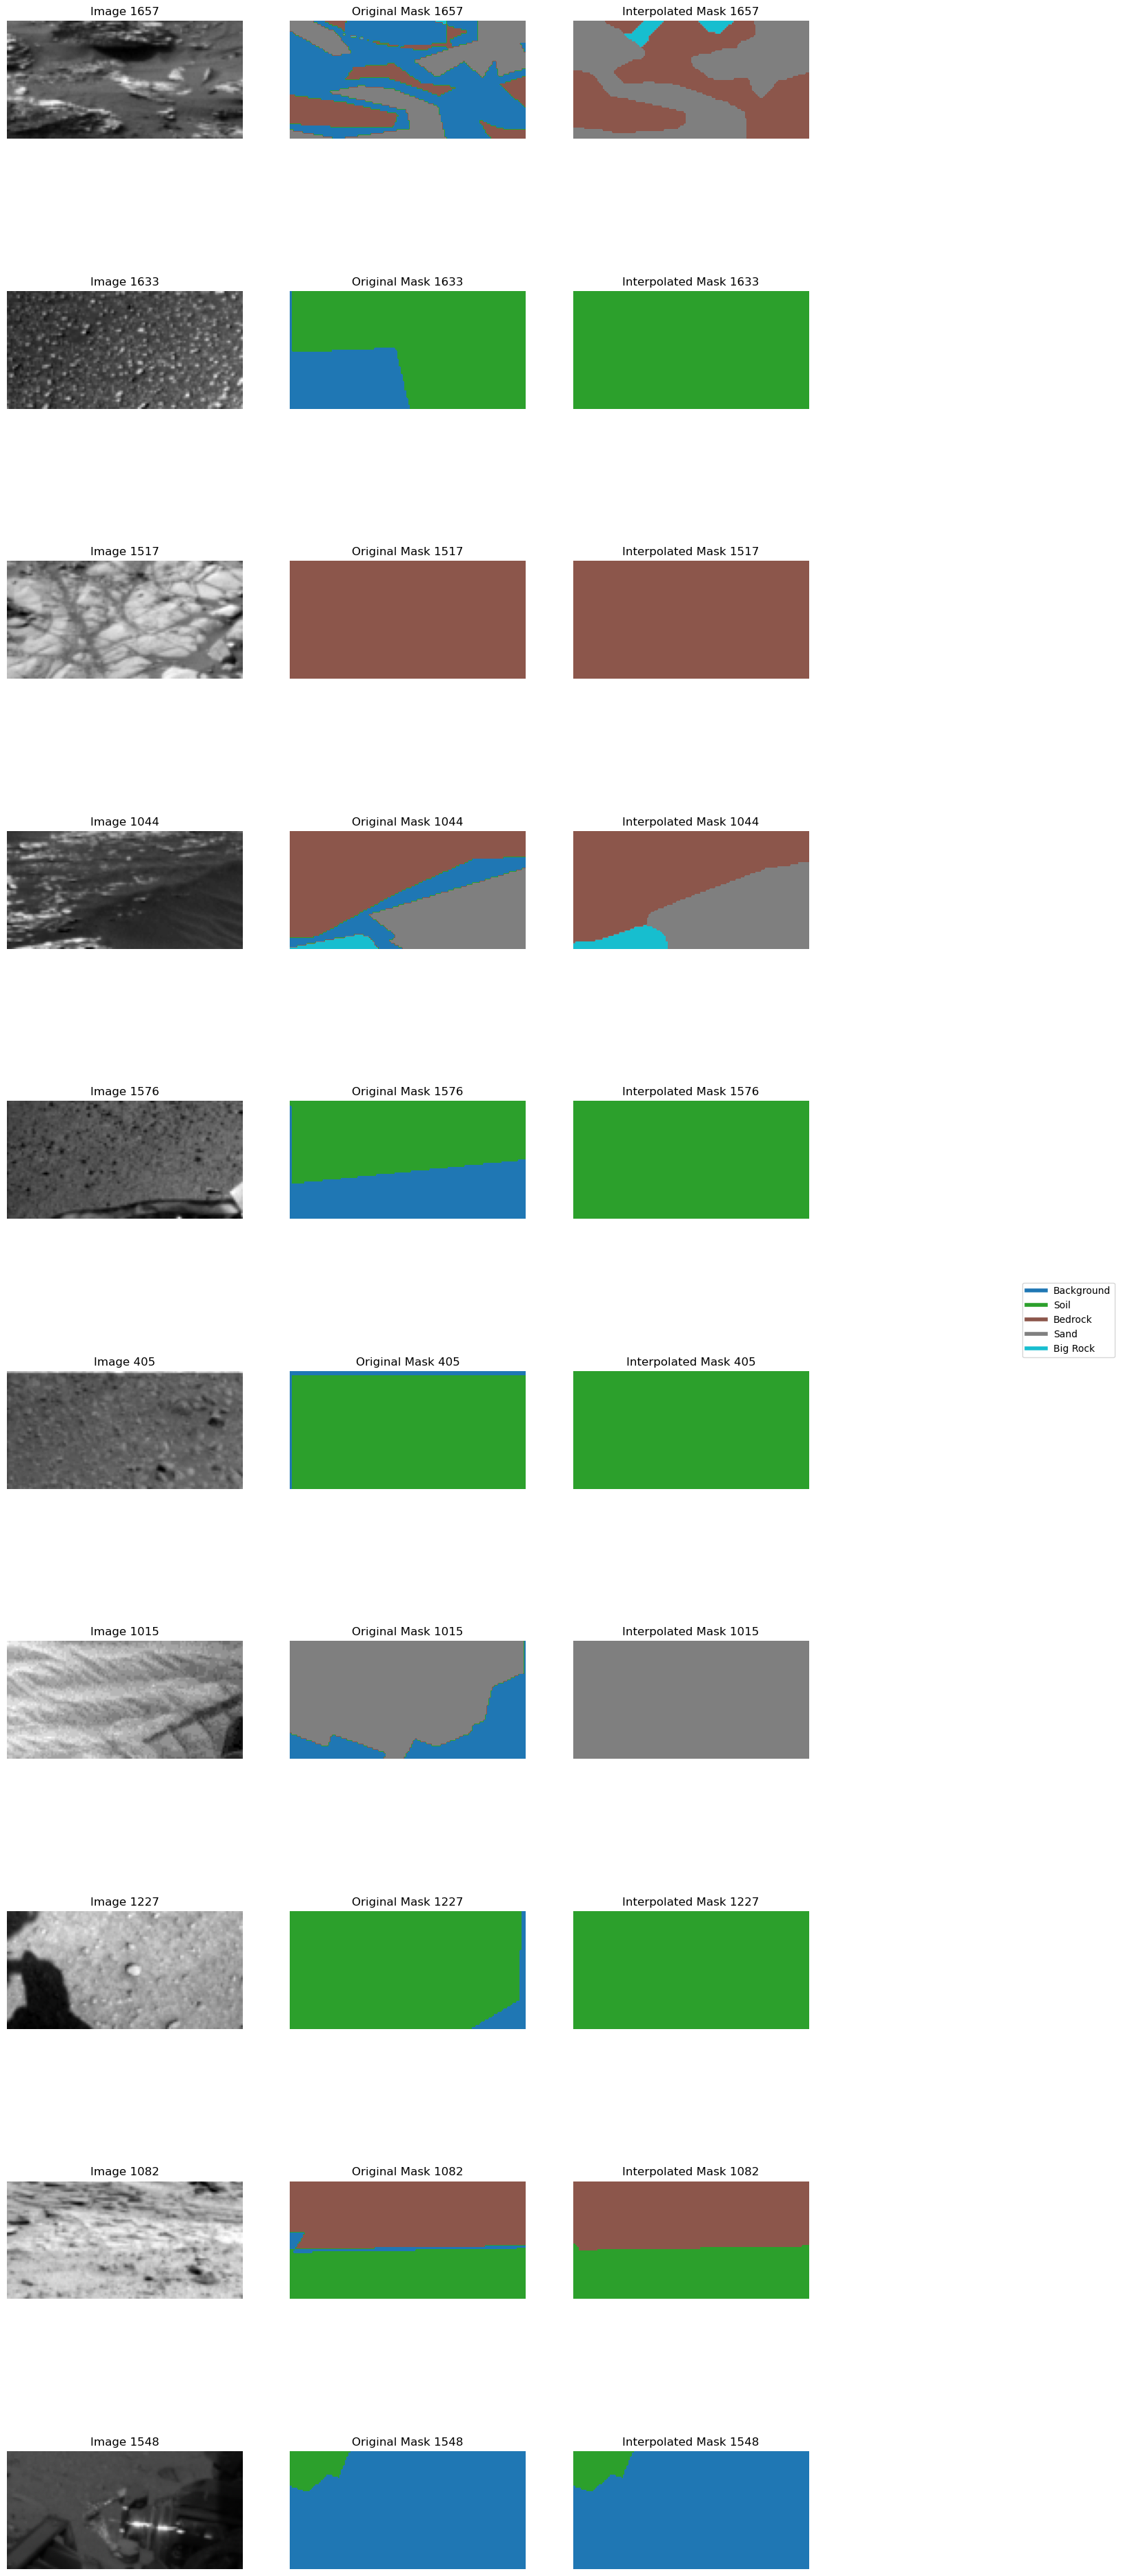

In [6]:
# Pick 10 random samples
random_indices = np.random.choice(len(X_train), 10, replace=False)

# Interpolate the selected masks
selected_masks = y_train[random_indices]
interpolated_selected_masks = interpolate_masks(selected_masks)

# Plot the images, original masks, and interpolated masks
fig, axes = plt.subplots(10, 3, figsize=(15, 50))

for i, idx in enumerate(random_indices):
    axes[i, 0].imshow(X_train[idx], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Image {idx}')
    
    axes[i, 1].imshow(y_train[idx], cmap=cmap, vmin=0, vmax=4)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Original Mask {idx}')
    
    axes[i, 2].imshow(interpolated_selected_masks[i], cmap=cmap, vmin=0, vmax=4)
    axes[i, 2].axis('off')
    axes[i, 2].set_title(f'Interpolated Mask {idx}')

# Create a legend for the labels
labels = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
handles = [plt.Line2D([0], [0], color=cmap(i), lw=4) for i in range(5)]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 0.5))
plt.show()

In [7]:
y_train = interpolate_masks(y_train)

Interpolating masks: 100%|██████████| 2205/2205 [02:29<00:00, 14.79it/s]


In [8]:
# Save the interpolated masks
np.savez_compressed('../../data/new_beggining/interpolated_trainning_clean_mars.npz', X_train=X_train, y_train=y_train, X_test=X_test)

Class Distribution:
Class 0: 1189061 pixels
Class 1: 7238696 pixels
Class 2: 5505698 pixels
Class 3: 4042756 pixels
Class 4: 87149 pixels


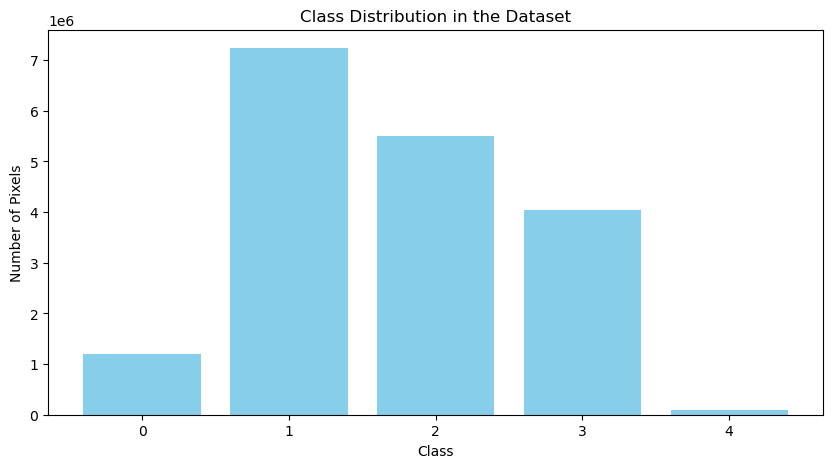

In [9]:
# Flatten the masks to count the occurrences of each class
flattened_masks = y_train.flatten()

# Count the occurrences of each class
unique, counts = np.unique(flattened_masks, return_counts=True)

# Create a dictionary to store the class distribution
class_distribution = dict(zip(unique, counts))

# Print the class distribution
print("Class Distribution:")
for cls, count in class_distribution.items():
    print(f"Class {int(cls)}: {count} pixels")

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Pixels')
plt.title('Class Distribution in the Dataset')
plt.xticks(list(class_distribution.keys()))
plt.show()

C:\Users\camil\AppData\Local\Temp\ipykernel_21300\1983978628.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(y_pca_interpolated[:, 0], y_pca_interpolated[:, 1], cmap='tab10', alpha=0.5)


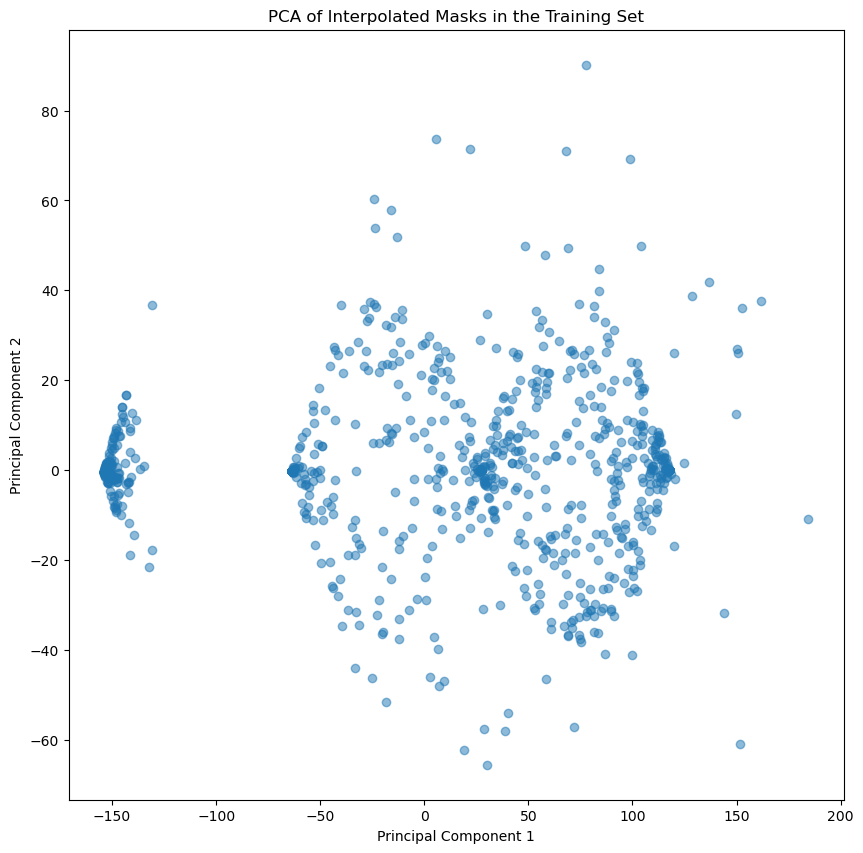

In [10]:
from sklearn.decomposition import PCA

# Flatten the interpolated masks
interpolated_masks_flattened = y_train.reshape(y_train.shape[0], -1)

# Apply PCA
pca_interpolated = PCA(n_components=2)
y_pca_interpolated = pca_interpolated.fit_transform(interpolated_masks_flattened)

# Plot the PCA results
plt.figure(figsize=(10, 10))
plt.scatter(y_pca_interpolated[:, 0], y_pca_interpolated[:, 1], cmap='tab10', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Interpolated Masks in the Training Set')
plt.show()

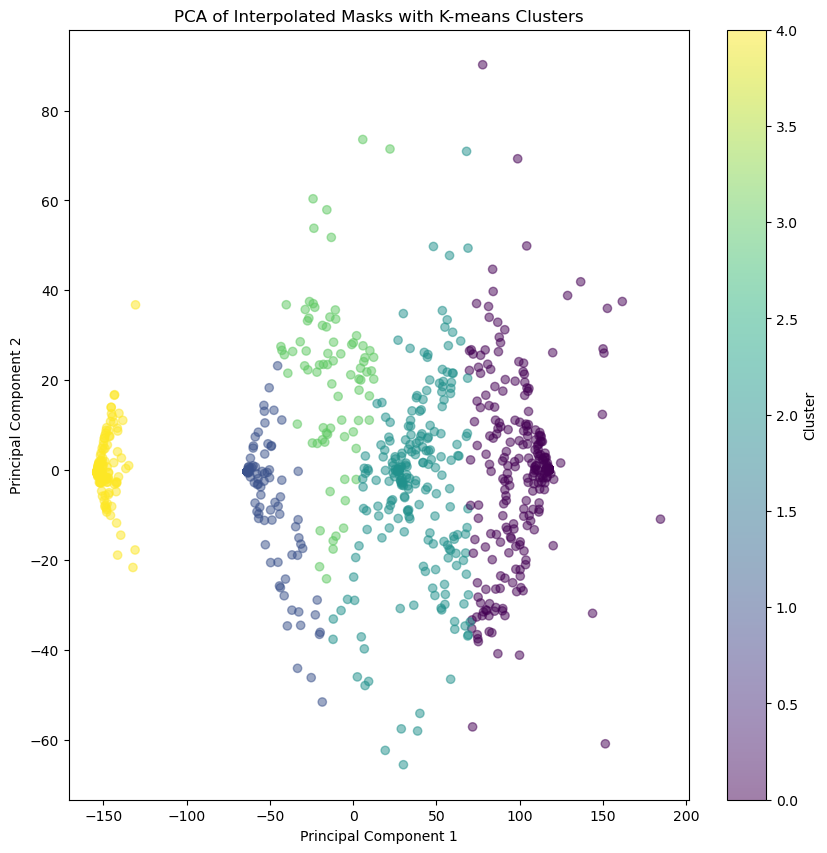

In [12]:
from sklearn.cluster import KMeans

# Perform K-means clustering with 4 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(y_pca_interpolated)

# Plot the PCA results with the K-means cluster labels
plt.figure(figsize=(10, 10))
plt.scatter(y_pca_interpolated[:, 0], y_pca_interpolated[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Interpolated Masks with K-means Clusters')
plt.colorbar(label='Cluster')
plt.show()

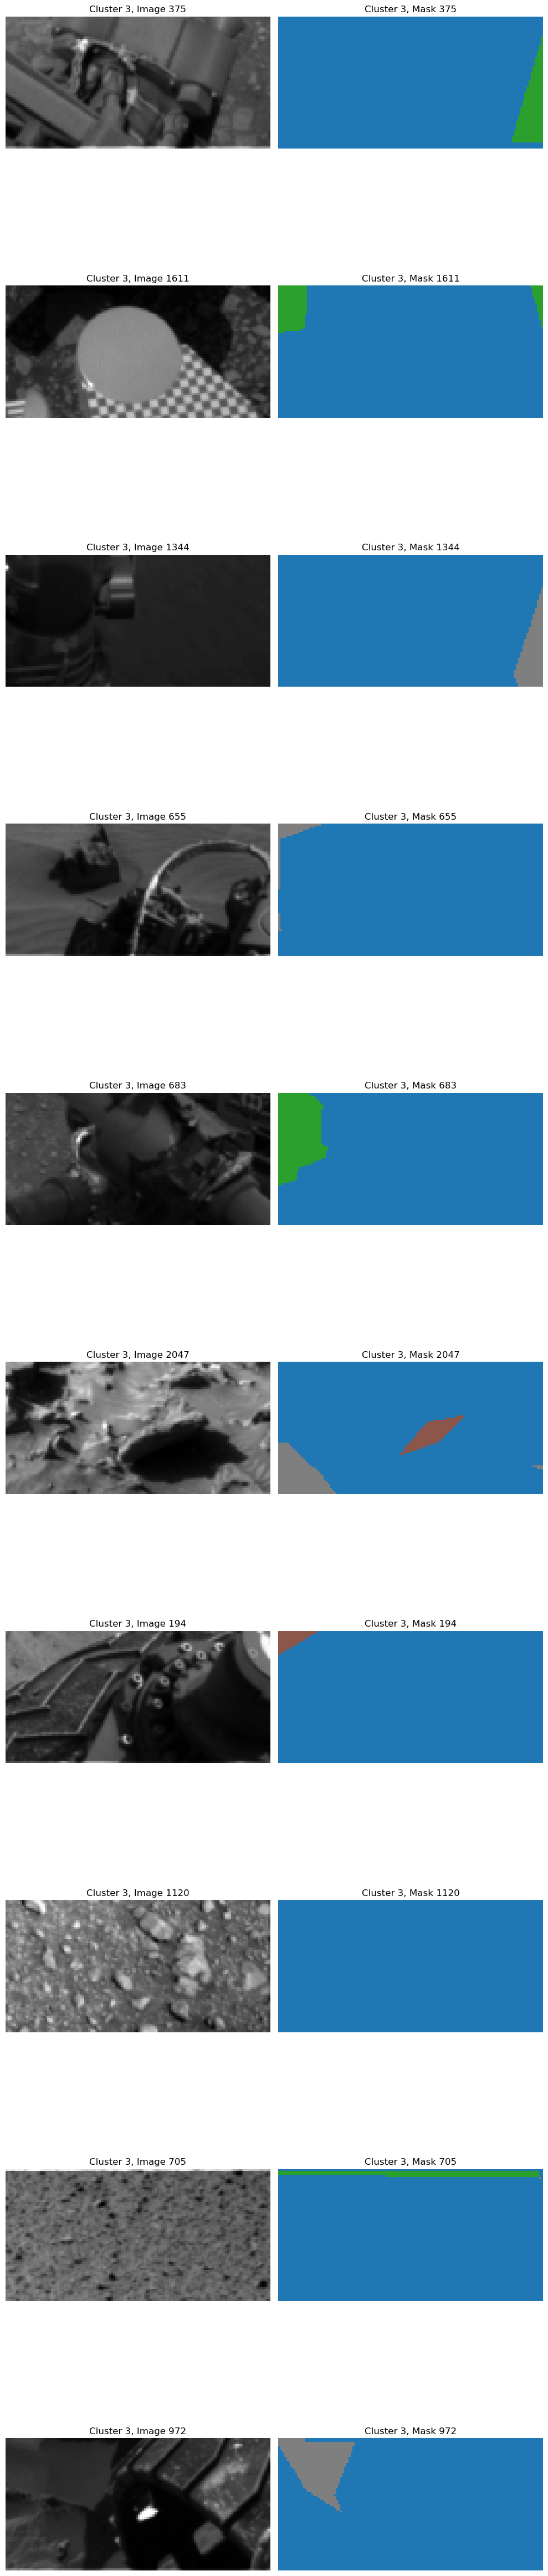

In [14]:
# Get the indices of images in cluster 3
cluster_4_indices = np.where(kmeans_labels == 4)[0]

# Select 10 random indices from cluster 3
random_cluster_4_indices = np.random.choice(cluster_4_indices, 10, replace=False)

# Plot the images and their corresponding masks
fig, axes = plt.subplots(10, 2, figsize=(10, 50))
for i, idx in enumerate(random_cluster_4_indices):
    axes[i, 0].imshow(X_train[idx], cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Cluster 3, Image {idx}')
    
    axes[i, 1].imshow(y_train[idx], cmap=cmap, vmin=0, vmax=4)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Cluster 3, Mask {idx}')

plt.tight_layout()
plt.show()

In [15]:
# Print the number of images in cluster 3
num_images_cluster_4 = len(cluster_4_indices)
print(f"Number of images in cluster 3: {num_images_cluster_4}")

Number of images in cluster 3: 150


In [16]:
# Get the indices of images not in cluster 3
indices_to_keep = np.where(kmeans_labels != 4)[0]

# Filter out the images and masks corresponding to cluster 3
X_train_filtered = X_train[indices_to_keep]
y_train_filtered = y_train[indices_to_keep]

# Update the original variables
X_train = X_train_filtered
y_train = y_train_filtered

# Print the shapes of the new datasets
print("New shape of X_train:", X_train.shape)
print("New shape of y_train:", y_train.shape)

New shape of X_train: (2055, 64, 128)
New shape of y_train: (2055, 64, 128)


In [17]:
import os

# Create the directory if it doesn't exist
output_dir = '../../data/new_beggining'

# Save the dataset with the new name
output_path_no_background = os.path.join(output_dir, 'no_background_interpolated_trainning_clean_mars.npz')
np.savez_compressed(output_path_no_background, X_train=X_train, y_train=y_train, X_test=X_test)

print(f"Dataset saved to {output_path_no_background}")

Dataset saved to ../../data/new_beggining\no_background_interpolated_trainning_clean_mars.npz
